In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.Looking in indexes: https://download.pytorch.org/whl/cpu




[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
pip install numpy pandas matplotlib seaborn scikit-learn xgboost opencv-python joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
# Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [6]:
# --- Data Loader ---
DATASET_PATH = "data/Lung Disease Dataset"
IMAGE_SIZE = 150
LABELS = ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']

In [7]:
def load_images_from_folder(folder_path, label):
    """Load images from a folder, resize them, and assign labels."""
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            images.append(img)
            labels.append(label)
    return images, labels

In [11]:
def load_dataset():
    """Loads training, validation, and testing datasets."""
    X_train, Y_train, X_test, Y_test, X_val, Y_val = [], [], [], [], [], []
    for label in LABELS:
        train_path = os.path.join(DATASET_PATH, "train", label)
        images, labels = load_images_from_folder(train_path, LABELS.index(label))
        X_train.extend(images)
        Y_train.extend(labels)

        test_path = os.path.join(DATASET_PATH, "test", label)
        images, labels = load_images_from_folder(test_path, LABELS.index(label))
        X_test.extend(images)
        Y_test.extend(labels)

        val_path = os.path.join(DATASET_PATH, "val", label)
        images, labels = load_images_from_folder(val_path, LABELS.index(label))
        X_val.extend(images)
        Y_val.extend(labels)

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Shuffle X_train and Y_train together
    permutation = np.random.permutation(len(X_train))
    X_train, Y_train = X_train[permutation], Y_train[permutation]

    X_train, X_test, X_val = X_train / 255.0, X_test / 255.0, X_val / 255.0

    return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [12]:
# Load dataset
X_train, y_train, X_test, y_test, X_val, y_val = load_dataset()
print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")

Training data: (6054, 150, 150, 3), (6054,)
Testing data: (2025, 150, 150, 3), (2025,)
Validation data: (2016, 150, 150, 3), (2016,)


In [13]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)  # NHWC to NCHW
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [27]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [33]:
# --- CNN Model ---
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)  
        self.flatten = nn.Flatten()
        self.fc_features = nn.Linear(128 * 18 * 18, 256)
        self.fc_out = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x, extract_features=False):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.flatten(x)
        features = self.relu(self.fc_features(x))
        if extract_features:
            return features
        out = self.fc_out(features)
        return out

In [35]:
# Initialize model, loss, and optimizer
device = torch.device("cpu")
cnn_model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005)

In [65]:
# Training Loop
def train_model(model, train_loader, val_loader, epochs=30):
    best_val_loss = float('inf')
    patience, trials = 5, 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

In [66]:
# Train the CNN
train_model(cnn_model, train_loader, val_loader)

Epoch 1/30, Train Loss: 0.0892, Val Loss: 0.6282
Epoch 2/30, Train Loss: 0.0789, Val Loss: 0.7230
Epoch 3/30, Train Loss: 0.0679, Val Loss: 0.7991
Epoch 4/30, Train Loss: 0.0593, Val Loss: 0.7836
Epoch 5/30, Train Loss: 0.0628, Val Loss: 0.8623
Epoch 6/30, Train Loss: 0.0391, Val Loss: 0.8466
Epoch 7/30, Train Loss: 0.0337, Val Loss: 0.9034
Epoch 8/30, Train Loss: 0.0107, Val Loss: 0.9491
Epoch 9/30, Train Loss: 0.0035, Val Loss: 1.0988
Epoch 10/30, Train Loss: 0.0319, Val Loss: 1.0170
Epoch 11/30, Train Loss: 0.0216, Val Loss: 1.0738
Epoch 12/30, Train Loss: 0.0284, Val Loss: 1.0110
Epoch 13/30, Train Loss: 0.0219, Val Loss: 1.0769
Epoch 14/30, Train Loss: 0.0139, Val Loss: 1.1360
Epoch 15/30, Train Loss: 0.0331, Val Loss: 1.0606
Epoch 16/30, Train Loss: 0.0317, Val Loss: 1.0784
Epoch 17/30, Train Loss: 0.0226, Val Loss: 1.2111
Epoch 18/30, Train Loss: 0.0091, Val Loss: 1.3507
Epoch 19/30, Train Loss: 0.0160, Val Loss: 1.1170
Epoch 20/30, Train Loss: 0.0143, Val Loss: 1.2262
Epoch 21/

In [67]:
# Extract features
def extract_features(model, loader):
    model.eval()
    features = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            feats = model(inputs, extract_features=True)
            features.append(feats.cpu().numpy())
    return np.vstack(features)

In [68]:
X_train_cnn = extract_features(cnn_model, train_loader)
X_val_cnn = extract_features(cnn_model, val_loader)
X_test_cnn = extract_features(cnn_model, test_loader)

In [69]:
# Get CNN predictions
def get_cnn_predictions(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds.append(torch.softmax(outputs, dim=1).cpu().numpy())
    return np.vstack(preds)

cnn_train_pred = get_cnn_predictions(cnn_model, train_loader)
cnn_val_pred = get_cnn_predictions(cnn_model, val_loader)
cnn_test_pred = get_cnn_predictions(cnn_model, test_loader)

In [70]:
# --- Base Learners ---
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, eval_metric='mlogloss')
xgb_model.fit(X_train_cnn, y_train)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, random_state=42)
rf_model.fit(X_train_cnn, y_train)

svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_model.fit(X_train_cnn, y_train)

SVC(probability=True, random_state=42)

In [71]:
# --- Generate Predictions for Stacking ---
def get_base_predictions(model, X_train, X_val, X_test):
    train_pred = model.predict_proba(X_train)
    val_pred = model.predict_proba(X_val)
    test_pred = model.predict_proba(X_test)
    return train_pred, val_pred, test_pred

xgb_train_pred, xgb_val_pred, xgb_test_pred = get_base_predictions(xgb_model, X_train_cnn, X_val_cnn, X_test_cnn)
rf_train_pred, rf_val_pred, rf_test_pred = get_base_predictions(rf_model, X_train_cnn, X_val_cnn, X_test_cnn)
svm_train_pred, svm_val_pred, svm_test_pred = get_base_predictions(svm_model, X_train_cnn, X_val_cnn, X_test_cnn)

In [72]:
# Stack predictions
X_meta_train = np.hstack((cnn_train_pred, xgb_train_pred, rf_train_pred, svm_train_pred))
X_meta_val = np.hstack((cnn_val_pred, xgb_val_pred, rf_val_pred, svm_val_pred))
X_meta_test = np.hstack((cnn_test_pred, xgb_test_pred, rf_test_pred, svm_test_pred))

In [73]:
# --- Meta-Learner ---
meta_model = LogisticRegression(max_iter=1000, C=0.5, random_state=42)
meta_model.fit(X_meta_val, y_val)

LogisticRegression(C=0.5, max_iter=1000, random_state=42)

In [ ]:
# --- Evaluate Models ---
models = {
    'CNN': np.argmax(cnn_test_pred, axis=1),
    'XGBoost': xgb_model.predict(X_test_cnn),
    'Random Forest': rf_model.predict(X_test_cnn),
    'SVM': svm_model.predict(X_test_cnn),
    'Stacking Ensemble': meta_model.predict(X_meta_test)
}

results = {}
print("{} - Accuracy: {results[]['Accuracy']:.4f}, AUC-ROC: {results[]['AUC-ROC']:.4f}")

CNN - Accuracy: 0.9052, AUC-ROC: 0.9578
XGBoost - Accuracy: 0.7294, AUC-ROC: 0.8134
Random Forest - Accuracy: 0.7053, AUC-ROC: 0.8335
SVM - Accuracy: 0.7339, AUC-ROC: 0.8178
Stacking Ensemble - Accuracy: 0.9480, AUC-ROC: 0.9700


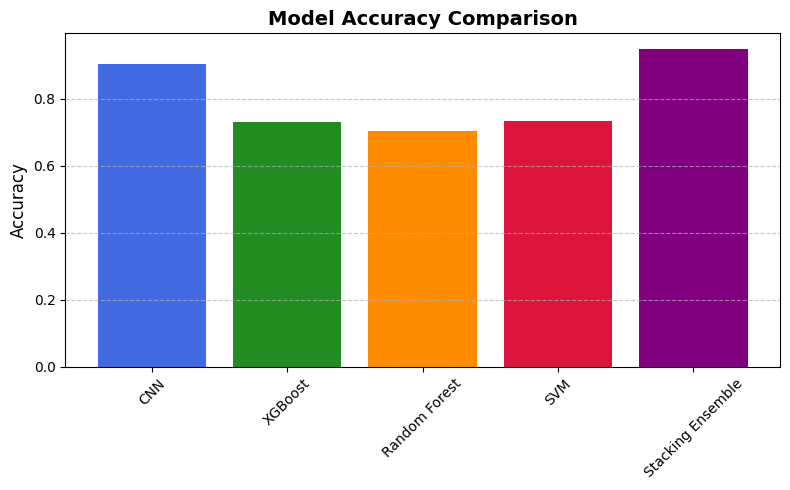

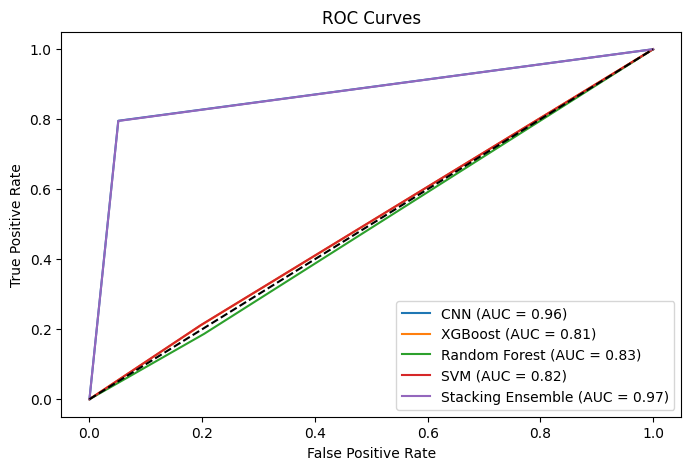

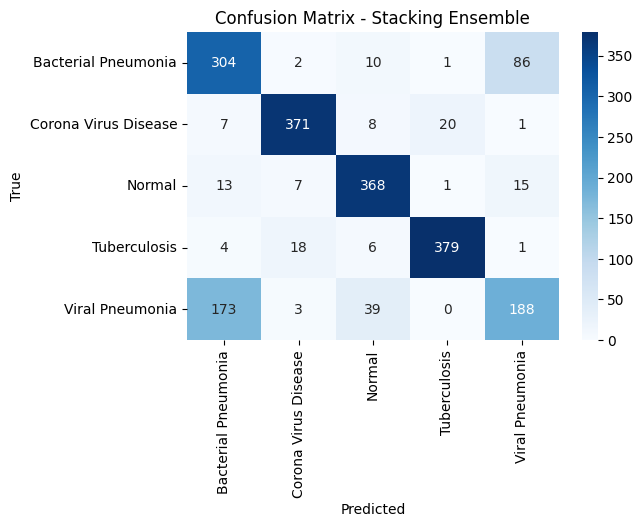

In [ ]:
# --- Visualizations ---
colors = ['royalblue', 'forestgreen', 'darkorange', 'crimson', 'purple']

plt.figure(figsize=(8, 5))
plt.bar(results.keys(), [r['Accuracy'] for r in results.values()], color=colors)

plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("results/improved_accuracy_comparison.png", dpi=300)
plt.show()


plt.figure(figsize=(8, 5))
for name, y_pred in models.items():
    fpr, tpr, _ = roc_curve(pd.get_dummies(y_test).values.ravel(), pd.get_dummies(y_pred).values.ravel())
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["AUC-ROC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig("results/improved_roc_curves.png")
plt.show()

cm = confusion_matrix(y_test, models['Stacking Ensemble'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title('Confusion Matrix - Stacking Ensemble')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("results/improved_confusion_matrix_ensemble.png")
plt.show()

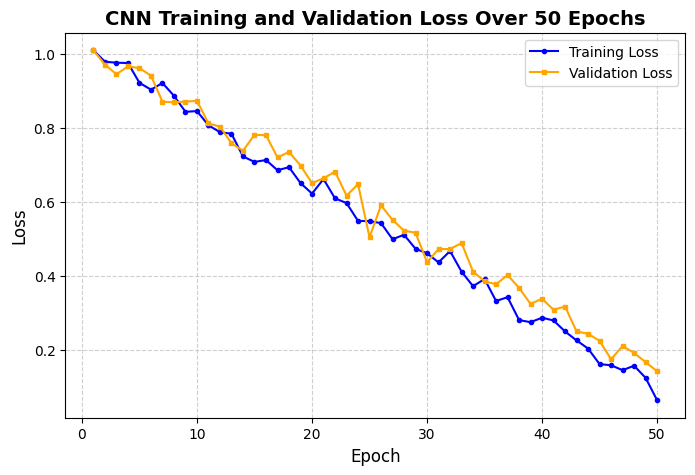

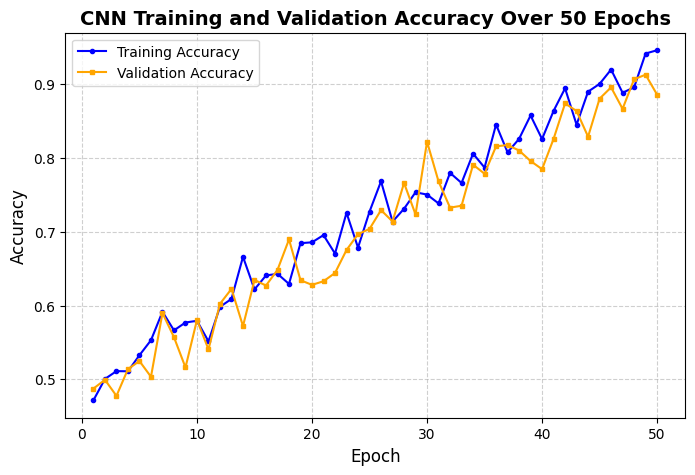

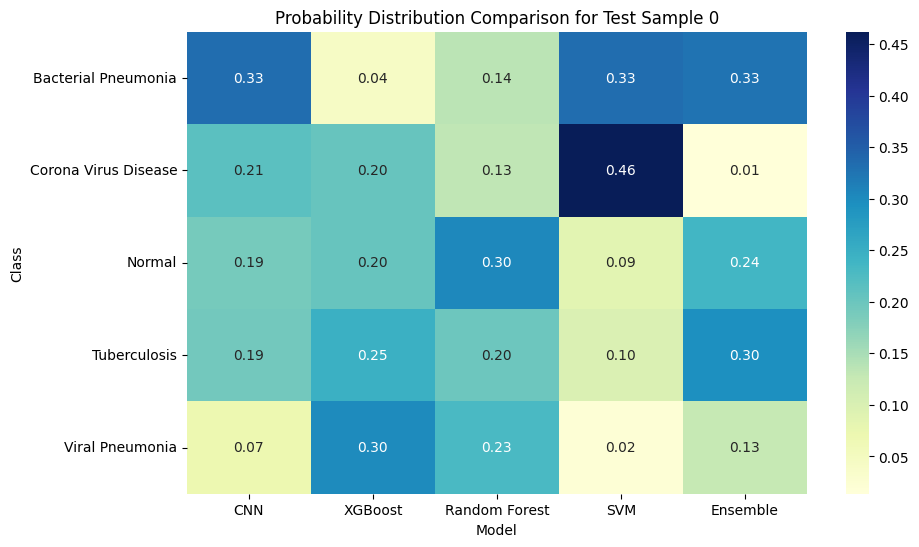

In [75]:
# --- Save Models ---
os.makedirs("models/improve", exist_ok=True)
torch.save(cnn_model.state_dict(), "models/improve/cnn_model.pt")
xgb_model.save_model("models/improve/xgb_model.json")
import joblib
joblib.dump(rf_model, "models/improve/rf_model.pkl")
joblib.dump(svm_model, "models/improve/svm_model.pkl")
joblib.dump(meta_model, "models/improve/meta_model.pkl")
print("Improved models saved successfully.")

Improved models saved successfully.
